In [1]:
# Download data from GitHub
!pip install wget -qU
import wget
import os.path

def download_from_our_github_repo(file_path, force_new_download=False):
  if force_new_download and os.path.isfile(file_path):
    os.remove(file_path)
  if force_new_download or not os.path.isfile(file_path):
      url = f"https://github.com/ko-redtruck/facial-landmark-detection/raw/main/{file_path}"  
      wget.download(url, ".")

## Download helper functions


In [2]:
download_from_our_github_repo('project-submission/data_loading.py')
download_from_our_github_repo('project-submission/data_visualisation.py')
download_from_our_github_repo('project-submission/train.py')

## The dataset

The dataset set contains 7049 black and white images with a resolution of 96x96. The labels are 15 facial landmarks each with x and y coordinates. Not all images have labels for all 15 facial landmarks. This reduces our dataset size to 2140 images.



In [3]:
from data_loading import get_facial_landmark_detection_data, preprocess_data
from data_visualisation import plot_images

images, labels = get_facial_landmark_detection_data('./data')

30


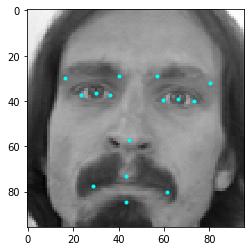

30


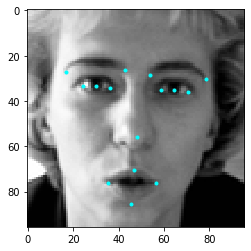

30


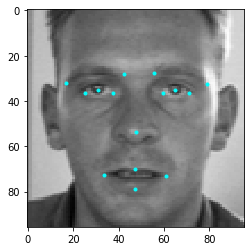

30


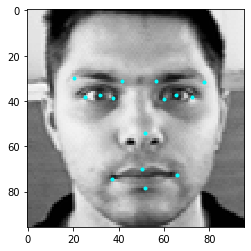

30


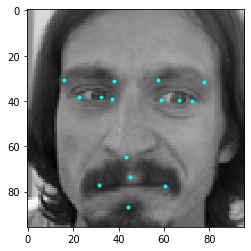

Images shape: (2140, 96, 96). Labels shape: (2140, 30)


In [4]:
plot_images(images, labels, num=5)
print(f"Images shape: {images.shape}. Labels shape: {labels.shape}")

## Data augmentation

Each image is randomly resized, repositioned and rotated. Changes in brightness, sharpness, hue and colors are also randomized. The empty space resulting from geometric transformations are filled with noise, a random solid color or the pixels from the edge.

Final image shape: torch.Size([3, 224, 224])
30


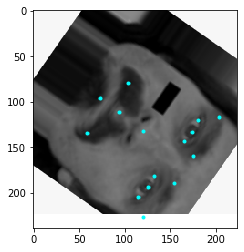

30


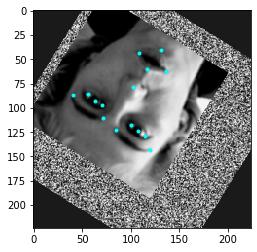

30


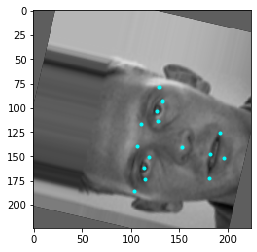

30


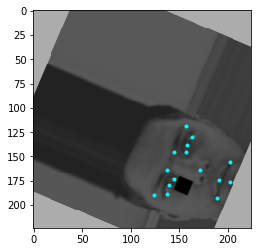

30


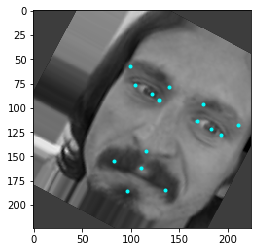

In [5]:
from data_loading import get_facial_landmark_detection_data, preprocess_data

preprocessed_images, preprocessed_labels = preprocess_data(images, labels, target_size=(224, 224),
                  dataset_multiplier=1,
                  max_crop_length=30, display_samples=False)
plot_images(preprocessed_images, preprocessed_labels, num=5)

## Model

You can choose our best Resnet18 or ResNet34 model. The larger ResNet34 model was trained on the rotated images. Both models use a custom output layer of Linear(512,256) then Relu and finally Linear(256,30).

To access them please download them from https://drive.google.com/drive/folders/13vn49AXvIuQvwhzh9xFZueLjGpKQNTn6. You can directly upload them to your runtime or upload them to your root GDrive folder and mount it.

In [6]:
resnet18_file = 'ResNet18(v20).pickle'
resnet34_file = 'ResNet34(v12).pickle'

if not os.path.isfile(resnet18_file) or not os.path.isfile(resnet34_file):
  print('Model files not in local runtime. Trying to mount Google Drive...')

  from google.colab import drive
  drive.mount('/content/drive')

  resnet18_file = '/content/drive/MyDrive/ResNet18(v20).pickle'
  resnet34_file = '/content/drive/MyDrive/ResNet34(v12).pickle'

Model files not in local runtime. Trying to mount Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
download_from_our_github_repo('project-submission/net_loading.py', force_new_download=True)

from torchvision.models import resnet18, resnet34, ResNet18_Weights, ResNet34_Weights
import torch
import torch.nn as nn

def add_final_layer(network, layer):
  network.fc = layer
  return network

def load_net(net_file: str, device):
  return torch.load(net_file, map_location=device)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NET_ARCHITECURE = 'ResNet34'
resnet34 = load_net(resnet34_file, device)
resnet18 = load_net(resnet18_file, device)

if NET_ARCHITECURE == 'ResNet34':
  net = resnet34
elif NET_ARCHITECURE == 'ResNet18':
  net = resnet18

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Prediction performance on the dataset

You can execute this code snippet to get the predictions on a random image (without augmentation and with) from our dataset. The red points are our model predictions and the blue ones the labels. If you use ResNet18 it will only perform good on non rotated images.

In [17]:
import torch
from PIL import ImageDraw
from torchvision import transforms
import numpy as np
from PIL import Image

def predict_facial_landmarks(*pil_images, net):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224)
    ])

    tensor_images = [preprocess(image.convert('L').convert('RGB')) for image in pil_images]
    image_batch = torch.stack(tensor_images, dim=0).to(device)
    net.eval()
    labels = net(image_batch)
    return labels.cpu().detach().numpy()


def add_labeling_to_images(*pil_images, labels):
    labelled_images = []
    for image, labeling in zip(pil_images, labels):
        draw = ImageDraw.Draw(image)
        points = zip(labeling[:-1:2], labeling[1::2])

        for point in points:
            x, y = point
            radius = 1
            upper_left_point = (x - radius, y - radius)
            lower_right_point = (x + radius, y + radius)
            draw.ellipse((upper_left_point, lower_right_point), fill=(255, 0, 0))
        labelled_images.append(image)
        
    return labelled_images


def predict_and_draw_facial_landmarks(*pil_images, net):
    resized_images = [transforms.functional.center_crop(image, [224]) for image in pil_images]
    labels = predict_facial_landmarks(*resized_images, net=net)
    labelled_images = add_labeling_to_images(*resized_images, labels=labels)
    return labelled_images

tensor_to_pil_image = transforms.ToPILImage()

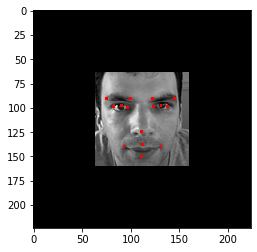

30


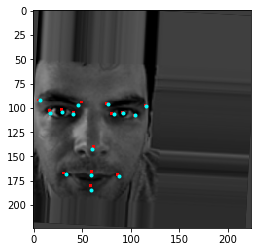

In [20]:
from random import randint 
random_image_index = randint(0, images.shape[0])

original_image = Image.fromarray(images[random_image_index]).convert('RGB')
augmented_image = tensor_to_pil_image(preprocessed_images[random_image_index]).convert('RGB')

original_labels = labels[random_image_index]
augmented_labels = preprocessed_labels[random_image_index]

predictions = predict_and_draw_facial_landmarks(original_image ,augmented_image, net=net)
plot_images(predictions, [None, augmented_labels])

## Load & predict demo video

We have provided a test video file but you can upload any mp4 videos to test the model.

In [10]:
download_from_our_github_repo('matthis_vid_v1.mp4')

In [13]:
from PIL import ImageDraw, Image
from datetime import timedelta
import numpy as np
Saving_frames_per_second = 30
import cv2

def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")

def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

def extract_frames_from(video_file):
  # read the video file    
  cap = cv2.VideoCapture(video_file)

  # Check if camera opened successfully
  if(cap.isOpened()== False):
	  print("Error opening video stream or file")
  # get the FPS of the video
  fps = cap.get(cv2.CAP_PROP_FPS)
  # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
  saving_frames_per_second = min(fps, Saving_frames_per_second)
  # get the list of duration spots to save
  saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
  # start the loop
  count = 0
  frames = []
  while True:
      is_read, frame = cap.read()
      if not is_read:
          # break out of the loop if there are no frames to read
          break
      # get the duration by dividing the frame count by the FPS
      frame_duration = count / fps
      try:
          # get the earliest duration to save
          closest_duration = saving_frames_durations[0]
      except IndexError:
          # the list is empty, all duration frames were saved
          break
      if frame_duration >= closest_duration:
          # if closest duration is less than or equals the frame duration, 
          # then save the frame
          frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
          #cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
          ## drop the duration spot from the list, since this duration spot is already saved
          frames.append(frame)
          try:
              saving_frames_durations.pop(0)
          except IndexError:
              pass
      # increment the frame count
      count += 1
  return frames


def opencv_to_pil_image(opencv_image):
  color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
  pil_image=Image.fromarray(color_coverted)
  return pil_image

def pil_to_opencv_image(pil_image):
  np_image=np.array(pil_image)  

  # convert to a openCV2 image, notice the COLOR_RGB2BGR which means that 
  # the color is converted from RGB to BGR format
  opencv_image=cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
  return opencv_image

def opencv_images_to_video(opencv_images,video_filename):
  height, width, layers = opencv_images[0].shape
  image_size = (width, height)

  out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'MP4V'), Saving_frames_per_second, image_size)
  for frame in opencv_images:
    out.write(frame)
  out.release()


In [11]:
from IPython.display import HTML
from base64 import b64encode
import os

def display_video_in_notebook(video_file):
  video_file_name = video_file.replace('.mp4','')
  compressed_path = f'{video_file_name}-compressed.mp4'

  if os.path.isfile(compressed_path):
    remove(compressed_path)

  os.system(f"ffmpeg -i {video_file} -vcodec libx264 {compressed_path}")
  mp4 = open(compressed_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=600 controls loop autoplay>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [14]:
from google.colab import output
from os import remove

#Change the test video to your own video :)
test_video_file = 'matthis_vid_v1.mp4'
output_video_file = 'video_predicted.mp4'

if os.path.isfile(output_video_file):
  os.remove(output_video_file)

frames = [opencv_to_pil_image(opencv_image) for opencv_image in extract_frames_from(test_video_file)]
predicted_landmarks = predict_and_draw_facial_landmarks(*frames,net=net)
opencv_images_to_video([pil_to_opencv_image(pil_image) for pil_image in predicted_landmarks],output_video_file)

display_video_in_notebook(output_video_file)